In [1]:
import sys
sys.path.append("..")


In [2]:
import os
import sys
import json
import joblib
import multiprocessing as mp
import time
import itertools
from pathlib import Path

import yaml
import pandas as pd
from dotenv import load_dotenv
from serpapi import GoogleSearch
import tiktoken
from openai import OpenAI
from tqdm import tqdm
load_dotenv()


from sheet import (get_serp, get_condensed_result, get_googlemap_results, 
    get_organic_result, 
    compose_query, compose_classification, compose_filter,
    classify_results, classify_results_mp, 
    filter_results, filter_results_mp, 
    crawl_results, crawl_results_mp,
    compose_extraction, extract_results, extract_results_mp,
    compose_regularization, regularize_results, regularize_results_mp,
    postprocess_result, continue_missing
)

from data import get_leads, split_data
from utils import reverse_category2supercategory

ORGANIZATION_ID = os.getenv("ORGANIZATION_ID") 
SERP_API_KEY = os.getenv("SERPAPI_API_KEY")

base = "https://serpapi.com/search.json" 
engine = 'google'
# query = "Coffee"
google_domain = 'google.com.tw'
gl = 'tw'
lr = 'lang_zh-TW'
# url = f"{base}?engine={engine}&q={query}&google_domain={google_domain}&gl={gl}&lr={lr}"

client = OpenAI( organization = ORGANIZATION_ID)

config = yaml.safe_load(open("../config/config.yml","r").read())


category2supercategory = config['category2supercategory']

supercategory2category = reverse_category2supercategory(category2supercategory)

n_processes =4 


/data1/env/py310helperbot/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 載入 config & prompt template ###

In [87]:
### --- regularization --- ###
config = yaml.safe_load(open("../config/config.yml","r"))
regularization_prompt = config['regularization_prompt']
# print( system_prompt )

jenv = jinja2.Environment()
category = "早餐"
template = jenv.from_string(regularization_prompt)
res = template.render( )
print( res )


As a helpful and factual assistant, your task is to classify the provided raw cuisine category into a conformed category. The definition of each conformed category is show below (in the format of `category`: `... definition ...`):
- `小吃店`:小吃、擔仔麵、小吃攤、街邊小店、傳統小吃、麵食、麵攤、炒飯、餃子館、鯊魚煙、黑白切、牛肉麵、銅板美食、小點心、簡餐、色小菜、開放空間攤販
- `日式料理(含居酒屋，串燒)`:居酒屋、酒場、水產、清酒、生魚片、壽司、日式啤酒、日式料理、代烤服務、日本餐飲場所、日本傳統食物、日式定食
- `火(鍋／爐)`:麻辣鍋、薑母鴨、鴨味仔、鍋物、湯底、滋補、冬令補、涮涮鍋、個人鍋、冬天圍爐、羊肉爐、鴛鴦鍋、炭火爐、氣火爐、燒酒雞、蒸氣海鮮鍋
- `東南亞料理(不含日韓)`:印尼、越式、泰式、沙嗲、海南雞、河粉、馬來西亞料理、新加坡料理、寮國料理、緬甸料理、南洋風味、印度料理、越南春捲、泰式綠咖哩、異國風情裝潢、滇緬料理
- `海鮮熱炒`:海鮮、現撈、活海鮮、生猛、大排檔、活魚活蝦、生猛海鮮、快炒、海產、台式海鮮、下酒菜
- `特色餐廳(含雞、鵝、牛、羊肉)`:烤鴨、燒鵝、甕仔雞、甕缸雞、桶仔雞、牛雜、蒙古烤肉、鵝肉城、金山鴨肉、生牛肉、全羊宴、活鱉、烤雞店、鵝肉餐廳、溫體牛、現宰羊肉、鹹水鵝、土羊肉
- `傳統餐廳`:江浙、台菜、合菜、桌菜、粵菜、中式、川菜、港式、上海菜、砂鍋魚頭、東北菜、北京烤鴨、一鴨三吃、婚宴、辦桌、老字號、宴會廳、台灣料理
- `燒烤`:燒烤、串燒、串串、烤魚、鮮蚵、炭烤、直火、碳火、和牛、戶外生火、烤肉、路邊燒烤
- `韓式料理(含火鍋，烤肉)`:韓國泡菜、韓式年糕、首爾、燒酒、韓式炸雞、春川辣炒雞、韓式炸醬麵、海鮮煎餅、烤三層肉、烤五花、烤韓牛、醬料和飯、石鍋拌飯、韓式風格、韓式清酒、啤酒、銅盤烤肉、韓流
- `PUB(Live Band)`:音樂餐廳、樂團表演、現場表演、LIVE表演、樂團駐唱、定期表演、有舞台場地、樂隊、專人駐唱
- `PUB(一般，含Lounge)`:酒吧、ba

### batch job ###

In [78]:
### --- both files have the same columns --- ###
with open("../data/gemini-1.5-flash/full-round-12/extracted_results.joblib", "rb") as f:
    extracted_results = joblib.load(f)
print( extracted_results['extracted_results'].columns )
print( extracted_results['extracted_results'])

with open("../data/gpt-4o-mini/output_0402_1_篩選結果.xlsx - Sheet1_9/extracted_results.joblib", "rb") as f:
    extracted_results2 = joblib.load(f)
print( extracted_results2['extracted_results'].columns )
print( extracted_results2['extracted_results'] )


Index(['index', 'business_id', 'business_name', 'evidence', 'store_name',
       'address', 'description', 'category', 'phone_number',
       'provide_alcohol'],
      dtype='object')

In [90]:
for i, d in enumerate(extracted_results2['extracted_results'].itertuples()):
    print( d.business_id, d.category)

92280632 日式料理(含居酒屋，串燒)
82539611 
92270971 小吃店
93462548 小吃店
95952921 早餐
47549802 小吃店
20335237 傳統餐廳
26924627 傳統餐廳
45361990 火(鍋／爐)
5989742 傳統餐廳
17295957 小吃店
87194518 傳統餐廳
72451073 早餐
39687823 
94487618 印尼菜
93480187 特色餐廳(含雞、鵝、牛、羊肉)
13957884 小吃店
13726596 小吃店
92207979 小吃店
72461781 日式料理(含居酒屋，串燒)
39695892 早餐
93407709 
13957189 早餐
88416144 小吃店
39756187 小吃店
21485629 小吃店
21479725 小吃店
80039018 
80039039 傳統餐廳
78132956 小吃店
98832915 小吃店
45475023 
26875421 小吃店
92277947 
26867962 
93345090 傳統餐廳
38923829 小吃店
85991002 
39764243 特色餐廳(含雞、鵝、牛、羊肉)
72431892 燒烤
13958666 小吃店
47376409 傳統餐廳
88460210 傳統餐廳
60236374 傳統餐廳
98832936 素食料理
38912718 特色餐廳(含雞、鵝、牛、羊肉)
85996631 小吃店
92321438 小吃店
18187463 
14851282 小吃店
47559287 
88593611 小吃店
78134384 小吃店
72392602 小吃店
47540099 小吃店
94483964 小吃店
85996230 自助KTV(含連鎖，庭園自助)
14850093 小吃店
92270402 咖啡廳(泡沫紅茶)
72583692 小吃店
47367892 傳統餐廳
14628398 中式麵食
17307047 傳統餐廳
38940496 特色餐廳(含雞、鵝、牛、羊肉)
72605957 小吃店
72381990 特色餐廳(含雞、鵝、牛、羊肉)
13951994 素食料理
14637376 小吃店
21427902 百貨公司
25461346 
14635948 傳統餐廳

In [101]:
### ---- check number of records ---- ###
# ../data/gpt-4o-mini/output_0402_1_篩選結果.xlsx - Sheet1_14/crawled_results.joblib ../data/gpt-4o-mini/output_0402_1_篩選結果.xlsx - Sheet1_14/extracted_results.joblib 999 998
# ../data/gpt-4o-mini/output_0402_1_篩選結果.xlsx - Sheet1_2/crawled_results.joblib ../data/gpt-4o-mini/output_0402_1_篩選結果.xlsx - Sheet1_2/extracted_results.joblib 1000 999
### ####
import glob
extracted_file_paths = sorted(list(glob.glob(f"../data/gpt-4o-mini/output_0402_2_篩選結果.xlsx - Sheet1*/extracted_results.joblib", recursive=True)))
crawled_file_paths = sorted(list(glob.glob(f"../data/gpt-4o-mini/output_0402_2_篩選結果.xlsx - Sheet1*/crawled_results.joblib", recursive=True)))
for crawled_file_path, extracted_file_path in zip(crawled_file_paths, extracted_file_paths):
    with open( crawled_file_path, "rb") as f:
        cr = joblib.load(f)
    with open( extracted_file_path, "rb") as f:
        er = joblib.load(f)
    if cr['crawled_results'].shape[0]!=er['extracted_results'].shape[0]:
        print( crawled_file_path, extracted_file_path, cr['crawled_results'].shape[0], er['extracted_results'].shape[0])
    

../data/gpt-4o-mini/output_0402_2_篩選結果.xlsx - Sheet1_18/crawled_results.joblib ../data/gpt-4o-mini/output_0402_2_篩選結果.xlsx - Sheet1_18/extracted_results.joblib 1000 999
../data/gpt-4o-mini/output_0402_2_篩選結果.xlsx - Sheet1_24/crawled_results.joblib ../data/gpt-4o-mini/output_0402_2_篩選結果.xlsx - Sheet1_25/extracted_results.joblib 1000 999
../data/gpt-4o-mini/output_0402_2_篩選結果.xlsx - Sheet1_26/crawled_results.joblib ../data/gpt-4o-mini/output_0402_2_篩選結果.xlsx - Sheet1_27/extracted_results.joblib 1000 419
../data/gpt-4o-mini/output_0402_2_篩選結果.xlsx - Sheet1_27/crawled_results.joblib ../data/gpt-4o-mini/output_0402_2_篩選結果.xlsx - Sheet1_4/extracted_results.joblib 420 1000
../data/gpt-4o-mini/output_0402_2_篩選結果.xlsx - Sheet1_6/crawled_results.joblib ../data/gpt-4o-mini/output_0402_2_篩選結果.xlsx - Sheet1_8/extracted_results.joblib 1000 999


### 統計結果 ###

In [93]:
import seaborn as sns

missing_dfs, dfs = [], []
missing_data_dir = "../data/missing"
for i in range(1,5):
    pr = pd.read_csv(f"../data/staging/output_0402_{i}_篩選結果.xlsx - Sheet1.postprocessed.csv")
    pr = pr.drop(['evidence'], axis=1)
    missing_df = pr[pr['business_id'].isna()]
    num_missings = pr['business_id'].isna().sum()
    missing_dfs.append(missing_df)
    dfs.append(pr)
dfs = pd.concat(dfs, axis=0)
missing_dfs = pd.concat(missing_dfs, axis=0)

stats = pd.DataFrame( dfs['category'].value_counts().reset_index().rename({'index':'category', 'category': 'count'}, axis=1))
print( f"Total: {dfs.shape[0]}, missing data: { missing_dfs.shape[0] }, empty category: { dfs[dfs['category'].isna()].shape[0] }, clean-up: { stats['count'].sum() }")
stats.to_csv("../data/staging/summary.csv", index=False)



Total: 98633, missing data: 18, empty category: 9166, clean-up: 89467


In [94]:
dfs

營業地址      統一編號  總機構統一編號       營業人名稱      資本額  \
0                              營業地址      統一編號  總機構統一編號       營業人名稱      資本額   
1                宜蘭縣五結鄉協和村親河路二段２８１號  72810438      NaN       馬紹爾魚鍋   100000   
2          宜蘭縣宜蘭市建業里００６鄰建業路９２巷５７號１樓  99780204      NaN       昭洋海產行    30000   
3          宜蘭縣礁溪鄉德陽村００３鄰中山路二段１０６號１樓  29369573      NaN        來益魚行    30000   
4      屏東縣東港鎮朝安里朝隆路３９號（華僑市場Ｂ２２０號攤位）  89084214      NaN        曾鮮商號     3000   
...                             ...       ...      ...         ...      ...   
17790            高雄市鹽埕區育仁里五福四路２８號１樓  81007756      NaN       凱地啤酒屋   100000   
17791              高雄市鹽埕區育仁里五福四路３０號   8921964      NaN      合羽亭小吃店    50000   
17792            高雄市鹽埕區育仁里五福四路８８－１號  99058469      NaN      貓頭鷹啤酒屋   200000   
17793            高雄市鼓山區明誠里文忠路１４７號１樓  92153880      NaN     里奧餐飲企業社   100000   
17794            高雄市鼓山區龍水里美術東七街１２０號  59252804      NaN  簡單酒業股份有限公司  7500000   

          設立日期   組織別名稱  使用統一發票    行業代號     名稱  ...     名稱1   行業代號2   名稱2  \
0         設立日期   組織別名稱  使用統一發票    行業代號     名稱  ...     名稱1   行業代號2   名稱2   
1      1070330      獨資       Y  472311  水產品零售  ...      餐廳     NaN   NaN   
2       930721      獨資       Y  472311  水產品零售  ...      餐廳     NaN   NaN   
3       940414      獨資       N  472311  水產品零售  ...  麵店、小吃店     NaN   NaN   
4      1110719      獨資       N  472311  水產品零售  ...  麵店、小吃店     NaN   NaN   
...        ...     ...     ...     ...    ...  ...     ...     ...   ...   
17790  1061102      獨資       Y  563114    飲酒店  ...      餐廳     NaN   NaN   
17791   950330      獨資       N  563114    飲酒店  ...    飲料零售  561115    餐廳   
17792   921028      獨資       Y  563114    飲酒店  ...      餐廳     NaN   NaN   
17793  1111226      獨資       N  563114    飲酒店  ...      餐廳     NaN   NaN   
17794  1060515  股份有限公司       Y  563114    飲酒店  ...      餐廳  472913  菸酒零售   

       行業代號3  名稱3  index  business_id business_name         category  \
0      行業代號3  名稱3    0.0         統一編號         營業人名稱              NaN   
1        NaN  NaN    1.0     72810438         馬紹爾魚鍋           火(鍋／爐)   
2        NaN  NaN    2.0     99780204         昭洋海產行             海鮮熱炒   
3        NaN  NaN    3.0     29369573          來益魚行             海鮮熱炒   
4        NaN  NaN    4.0     89084214          曾鮮商號             海鮮熱炒   
...      ...  ...    ...          ...           ...              ...   
17790    NaN  NaN  790.0     81007756         凱地啤酒屋  PUB(一般，含Lounge)   
17791    NaN  NaN  791.0      8921964        合羽亭小吃店    日式料理(含居酒屋，串燒)   
17792    NaN  NaN  792.0     99058469        貓頭鷹啤酒屋  PUB(一般，含Lounge)   
17793    NaN  NaN  793.0     92153880       里奧餐飲企業社              NaN   
17794    NaN  NaN  794.0     59252804    簡單酒業股份有限公司  特色餐廳(含雞、鵝、牛、羊肉)   

      supercategory  
0               NaN  
1                中式  
2                中式  
3                中式  
4                中式  
...             ...  
17790            西式  
17791            中式  
17792            西式  
17793           NaN  
17794            中式  

[98633 rows x 21 columns]

### Main process ###

## 讀取資料名單 ##

In [3]:
output_dir = "../data/production"
# file_path = "../data/staging/output_0402_1_篩選結果.xlsx - Sheet1.csv"
# file_path = "../data/staging/output_0402_2_篩選結果.xlsx - Sheet1.csv"
# file_path = "../data/staging/output_0402_3_篩選結果.xlsx - Sheet1.csv"
file_path = "../data/staging/output_0402_4_篩選結果.xlsx - Sheet1.csv"
file_name = Path(file_path).stem
data = get_leads( file_path)
print(data.shape)
# data_list = split_data(data, samples = 1000)
# for i, d in enumerate(data_list):
#     output_file_path = Path(output_dir).joinpath(f"{file_name}_{i}.csv")
#     d.to_csv(output_file_path, index=False, header=None)
    

(17795, 16)


In [5]:
pr 

營業地址      統一編號   總機構統一編號             營業人名稱       資本額  \
0                    營業地址      統一編號   總機構統一編號             營業人名稱       資本額   
1       花蓮縣花蓮市國強里豐村１０１之３號  50741465       NaN              松田魚池     50000   
2         雲林縣口湖鄉湖口村湖口１２９號  87082295       NaN           勁豪水產養殖場    150000   
3       高雄市前鎮區明孝里漁港南一路３９號  24507540       NaN      隆順安全食品股份有限公司  50000000   
4       高雄市左營區新上里自由二路２２３號  25970691  24507540  隆順安全食品股份有限公司自由門市         0   
...                   ...       ...       ...               ...       ...   
17790  高雄市鹽埕區育仁里五福四路２８號１樓  81007756       NaN             凱地啤酒屋    100000   
17791    高雄市鹽埕區育仁里五福四路３０號   8921964       NaN            合羽亭小吃店     50000   
17792  高雄市鹽埕區育仁里五福四路８８－１號  99058469       NaN            貓頭鷹啤酒屋    200000   
17793  高雄市鼓山區明誠里文忠路１４７號１樓  92153880       NaN           里奧餐飲企業社    100000   
17794  高雄市鼓山區龍水里美術東七街１２０號  59252804       NaN        簡單酒業股份有限公司   7500000   

          設立日期   組織別名稱  使用統一發票    行業代號     名稱   行業代號1   名稱1   行業代號2  \
0         設立日期   組織別名稱  使用統一發票    行業代號     名稱   行業代號1   名稱1   行業代號2   
1      1060526      獨資       N  472311  水產品零售  932911   釣魚場  561113   
2      1091102      獨資       N  472311  水產品零售  561115    餐廳     NaN   
3       990209  股份有限公司       Y  472311  水產品零售  561115    餐廳  454399   
4       990527      其他       Y  472311  水產品零售  561115    餐廳  472999   
...        ...     ...     ...     ...    ...     ...   ...     ...   
17790  1061102      獨資       Y  563114    飲酒店  561115    餐廳     NaN   
17791   950330      獨資       N  563114    飲酒店  472914  飲料零售  561115   
17792   921028      獨資       Y  563114    飲酒店  561115    餐廳     NaN   
17793  1111226      獨資       N  563114    飲酒店  561115    餐廳     NaN   
17794  1060515  股份有限公司       Y  563114    飲酒店  561115    餐廳  472913   

                     名稱2   行業代號3                名稱3  
0                    名稱2   行業代號3                名稱3  
1                 麵店、小吃店     NaN                NaN  
2                    NaN     NaN                NaN  
3                其他水產品批發  472999  未分類其他食品、飲料及菸草製品零售  
4      未分類其他食品、飲料及菸草製品零售  454399            其他水產品批發  
...                  ...     ...                ...  
17790                NaN     NaN                NaN  
17791                 餐廳     NaN                NaN  
17792                NaN     NaN                NaN  
17793                NaN     NaN                NaN  
17794               菸酒零售     NaN                NaN  

[17795 rows x 16 columns]

## 進行爬蟲與分析 ##

In [ ]:

# crawled_results = crawl_results(data)
crawled_results = crawl_results_mp( data, args.crawled_file_path, n_processes=args.n_processes)



In [3]:
from sheet import get_serp, crawl_results, get_googlemap_results, get_organic_resuls
res = get_serp( 
    query = '致仙飲食店 澎湖縣 -inurl:twincn.com -inurl:findcompany.com.tw -inurl:iyp.com.tw -inurl:twypage.com -inurl:alltwcompany.com -inurl:zhupiter.com -inurl:twinc.com.tw', 
    google_domain = 'google.com.tw', gl = 'tw', lr = 'lang_zh-TW', provider = 'serper'
)


In [4]:
googlemap_res = get_googlemap_results(res)
search_res = get_organic_resuls(res)

## 方法 1: 擷取關鍵資訊與分類 ##

In [45]:

    # extracted_results = extract_results( 
    #     crawled_results['crawled_results']
    # )
extracted_results = extract_results_mp( 
        crawled_results = crawled_results['crawled_results'], 
        extracted_file_path = args.extracted_file_path
    )



total time: 0.003762483596801758


### 方法 1: 擷取關鍵資訊與分類 （ 20 records, 4 processes 46.84s) ##

In [10]:

st = time.time()
extract_file_path = "data/extracted_results.joblib"
if not os.path.exists(extract_file_path):
    split_data = split_dataframe( crawled_results['crawled_results'] )
    with mp.Pool(n_processes) as pool:
        extracted_results = pool.map( extract_results, split_data)
        extracted_results = merge_results( extracted_results, dataframe_columns=['extracted_results'], list_columns=['empty_indices'])
        with open( extract_file_path, "wb") as f:
            joblib.dump( extracted_results, f)
else:
    with open( extract_file_path, "rb") as f:
        extracted_results = joblib.load(f)

print( f"total time: {time.time() - st}")



5it [00:32,  6.60s/it]
5it [00:42,  8.59s/it]
5it [00:46,  9.28s/it]
5it [00:46,  9.36s/it]


total time: 46.843916177749634


### 方法2: 直接對爬蟲結果分類 ##

In [ ]:

    # classified_results = classify_results(  
    #     extracted_results['extracted_results'], 
    #     input_column = 'evidence',
    #     output_column = 'classified_category',
    #     classes = ['中式', '西式'],
    #     backup_classes = [ '中式', '西式']
    # )
classified_results = classify_results_mp( 
        extracted_results['extracted_results'], 
        args.classified_file_path, 
        classes=args.classes, 
        backup_classes=args.backup_classes, 
        n_processes=args.n_processes
    )



In [ ]:
## 合併分析結果 ##
combined_results = combine_results( 
        classified_results['classified_results'], 
        args.combined_file_path, 
        src_column='classified_category', 
        tgt_column='category', 
        strategy='replace'
    ) 



In [15]:
## 後處理分析結果 ##
postprossed_results = postprocess_result( 
        combined_results, 
        args.postprocessed_results,
        category2supercategory
    )


    

total time: 13.889266014099121


In [ ]:
## 調整輸出格式 
formatted_results = format_output( postprossed_results, input_column = 'evidence', output_column = 'formatted_evidence', format_func = format_evidence)
formatted_results.to_csv("data/formatted_results.csv", index=False)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.587 seconds.
Prefix dict has been built successfully.


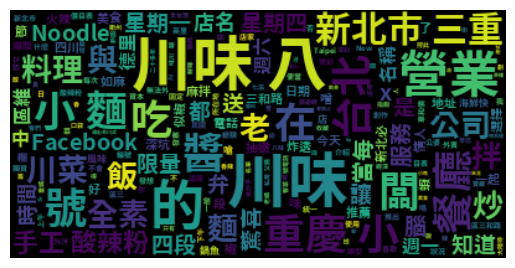

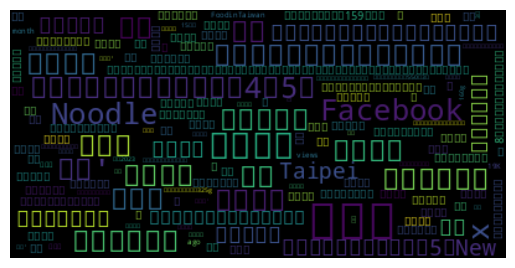

In [9]:
from wordcloud import WordCloud
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties as font
import jieba

# 設定字型的路徑
# myfont = font(fname="/data1/env/py310helperbot/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/TaipeiSansTCBeta-Bold.ttf")
# matplotlib.rc('font', family='sans',serif=['Taipei Sans TC Beta'])
# plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta'] # 修改中文字體
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
plt.rcParams['axes.unicode_minus'] = False


text = """
台北川味八-重慶小麵/手工酸辣粉外送| 菜單和價目表 (川味八-重慶小麵/手工酸辣粉在台北的價目表與外賣服務. 川味八-重慶小麵/手工酸辣粉. 4.4 x (66) • 6437.1 英里. x 無法外送. 新北市三重區三和路四段5號New Taipei, ...)
38 Noodle - 限量弁當每星期一與星期四腦闆 ... - Facebook (限量弁當每星期一與星期四腦闆固定創作發想日不會提前知道是什麼便當但每次推出都是驚喜讓我知道你喜歡這樣的驚喜嗎 🌶️店名：川味八公婆🌶️ ⌚️營業時間：週一～週六 ...)
川味八- 店家介紹 (統一編號. 92788743 · 公司狀況. 營業中 · 公司名稱. 川味八 · 公司類型. 獨資 · 資本總額. 100000 · 所在地. 新北市三重區維德里三和路4段5號 · 使用發票. 否 · 設立日期. 民國 ...)
38 Noodle - 今天情人節火辣在一起如麻似椒 ... - Facebook (今天情人節火辣在一起如麻似椒❤️❤️❤️ 🌶️店名：川味八🌶️ ⌚️營業時間：週一～週六 上午：11:00-14:00 下午：17:00-21:00 電話：0976529478 地址：新北市三重區三 ...)
川味不一般，全台灣只有這裡才吃得的衢州鮮辣| 旅遊經 (... 八味」之說，「七滋」指甜、酸、麻、辣、苦、香 ... 在大陸待了二十多年，川味的香辣早已經深深刻劃 ... 新北市深坑區深坑街159號電話：（02）2664-4879)
川菜控此篇必收藏！8間饕客們的台北寶藏口袋名單，讓人 ... (台北川菜餐廳推薦 · 真川味老舖 · 黔園川菜餐廳 · 四川吳炒手 · 皇城老媽川味私房料理 · 駱師父醬味川客菜 · 成都滿庭芳川式料理 · 四川蜀渝小吃.)
川味椒麻拌醬(全素) - 素食港式飲茶- 養心茶樓 (全素醬料，拌飯、拌麵、沾、炒、拌、烤百搭天王○ 川味椒麻拌醬：香麻上癮、不燥開胃、溫辣百搭○ 料理紅油抄手、麻辣鍋，襯出好滋味. 常溫商品【全素辣醬新選擇】)
川味八 (狀態, 營業中 ; 營業地址, 新北市三重區維德里三和路4段5號 ; 統編, 92788743 ; 營業名稱, 川味八 ; 資本額, 100,000.)
【新北必吃美食】炸透抽嫩/味噌蝦/海鮮快炒/爆漿飯糰/川味嗆鍋魚 ... (【新北必吃美食】炸透抽嫩/味噌蝦/海鮮快炒/爆漿飯糰/川味嗆鍋魚/無刺白帶魚卷/人氣包子店/小卷米粉@FoodinTaiwan. 19K views · 1 month ago #白帶魚 ...)
(即期品)康寶川味八香辣椒醬325g/瓶(效期2023/06/05) (台北市忠孝東路四段550號3樓. 保存期限, 15個月. 製造日期／有效 ... 丸美屋蠟筆小新甘口風味咖哩醬[附貼紙] 160g. $69 ... 川辣/泡菜(3入) 款式可選【小三美日】空運禁送 ...)
顧客評價： 麵食及酸辣粉都推薦半乾湯吃法～ 店面雖然很小卻別有一番風味～ 牛肉麵還可以免費加大 老闆，老闆娘很用心的服務 會再來吃！ 樓下開了好吃的重慶小麵啦～下次也想來試試紅油水餃 小菜選擇超多好讚👍👍

類似的店： ['中國菜'] ['餐廳'] ['燒烤'] ['熟食店'] ['餐廳']

電話號碼： 0976 529 478
"""
# Generate a word cloud image
wc_generator = WordCloud(font_path="/data1/env/py310helperbot/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/TaipeiSansTCBeta-Bold.ttf")
wordcloud = wc_generator.generate( " ".join(jieba.cut(text)))
fig, ax = plt.subplots()
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [15]:
from PIL import Image
isinstance(wordcloud.to_image(), Image.Image)


True

##  GEMINI 


In [27]:
import pathlib
import textwrap
import os

import google.generativeai as genai

from IPython.display import display
from IPython.display import Markdown


# from google.colab import userdata # Used to securely store your API key
from dotenv import load_dotenv
load_dotenv()

def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

genai.configure(api_key=os.getenv('GOOGLE_API_KEY'))

for m in genai.list_models():
  if 'generateContent' in m.supported_generation_methods:
    print(m.name)
      

In [28]:
model = genai.GenerativeModel('gemini-1.5-flash')



## completion mode

In [29]:
%%time
response = model.generate_content("What is the meaning of life?")
print( response.candidates )
to_markdown(response.text) 


[index: 0
content {
  parts {
    text: "The meaning of life is a profound and enduring question that has captivated philosophers, theologians, and individuals for centuries. There is no single, universally accepted answer, as the meaning of life is deeply personal and subjective.\n\nHere are some perspectives on the meaning of life:\n\n**1. Existentialism:** This philosophy emphasizes individual freedom and responsibility. Existentialists believe that life has no inherent meaning, and it is up to each person to create their own purpose and values.\n\n**2. Nihilism:** This perspective argues that life is meaningless and that there are no objective values or goals. Nihilists often believe that existence is absurd and that there is no point in striving for anything.\n\n**3. Religion and Spirituality:** Many religious traditions offer a framework for understanding the meaning of life. For example, Christianity teaches that the purpose of life is to love God and one\'s neighbor. Buddhism e

> The meaning of life is a profound and enduring question that has captivated philosophers, theologians, and individuals for centuries. There is no single, universally accepted answer, as the meaning of life is deeply personal and subjective.
> 
> Here are some perspectives on the meaning of life:
> 
> **1. Existentialism:** This philosophy emphasizes individual freedom and responsibility. Existentialists believe that life has no inherent meaning, and it is up to each person to create their own purpose and values.
> 
> **2. Nihilism:** This perspective argues that life is meaningless and that there are no objective values or goals. Nihilists often believe that existence is absurd and that there is no point in striving for anything.
> 
> **3. Religion and Spirituality:** Many religious traditions offer a framework for understanding the meaning of life. For example, Christianity teaches that the purpose of life is to love God and one's neighbor. Buddhism emphasizes the pursuit of enlightenment and liberation from suffering.
> 
> **4. Humanism:** This philosophy focuses on human values, reason, and ethics. Humanists believe that the meaning of life is found in pursuing happiness, fulfilling one's potential, and contributing to society.
> 
> **5. Hedonism:** This view emphasizes pleasure and the pursuit of happiness as the primary goals of life. Hedonists believe that the best life is one that maximizes pleasure and minimizes pain.
> 
> **6. Stoicism:** This philosophy emphasizes virtue, reason, and acceptance. Stoics believe that the meaning of life is to live in accordance with nature and to accept whatever happens with equanimity.
> 
> **7. The Meaning is in the Journey:** Some people believe that the meaning of life is not found in a specific goal or destination but in the journey itself. The experiences, relationships, and growth we encounter along the way are what give life meaning.
> 
> Ultimately, the meaning of life is a question that each individual must answer for themselves. There is no right or wrong answer, and the meaning may evolve and change over time. It is important to explore different perspectives, reflect on your own values and beliefs, and engage in meaningful activities that bring you joy and fulfillment.


In [30]:
response.candidates

[index: 0
content {
  parts {
    text: "The meaning of life is a profound and enduring question that has captivated philosophers, theologians, and individuals for centuries. There is no single, universally accepted answer, as the meaning of life is deeply personal and subjective.\n\nHere are some perspectives on the meaning of life:\n\n**1. Existentialism:** This philosophy emphasizes individual freedom and responsibility. Existentialists believe that life has no inherent meaning, and it is up to each person to create their own purpose and values.\n\n**2. Nihilism:** This perspective argues that life is meaningless and that there are no objective values or goals. Nihilists often believe that existence is absurd and that there is no point in striving for anything.\n\n**3. Religion and Spirituality:** Many religious traditions offer a framework for understanding the meaning of life. For example, Christianity teaches that the purpose of life is to love God and one\'s neighbor. Buddhism e

In [32]:
from google.generativeai.types import HarmCategory, HarmBlockThreshold

{
    HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,
    HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE,
    HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE,
    HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE,
}
# HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_LOW_AND_ABOVE,

(<HarmCategory.HARM_CATEGORY_HATE_SPEECH: 8>,
 <HarmBlockThreshold.BLOCK_LOW_AND_ABOVE: 1>)

## completion mode with streaming

In [20]:
%%time
response = model.generate_content("What is the meaning of life?", stream=True)
for chunk in response:
  print(chunk.text)
  print("_"*80)


The
________________________________________________________________________________
 meaning of life is a question that has been pondered by philosophers and theologians for centuries
________________________________________________________________________________
. There is no single, universally accepted answer, and the meaning you find will
________________________________________________________________________________
 likely be unique to you. 

Here are some perspectives on the meaning of life:

**Philosophical Perspectives:**

* **Nihilism:** This
________________________________________________________________________________
 view argues that life has no inherent meaning, and any meaning we find is self-created.
* **Existentialism:**  Focuses on individual freedom
________________________________________________________________________________
 and responsibility to create meaning in a world without inherent purpose.
* **Absurdism:**  Recognizes the inherent absurdity of life

## chat completion

In [21]:
model = genai.GenerativeModel('gemini-1.5-flash')
chat = model.start_chat(history=[])
response = chat.send_message("In one sentence, explain how a computer works to a young child.")
to_markdown(response.text)


> A computer is like a super smart toy that follows instructions you give it with buttons and words, and it shows you the results on a screen. 


In [22]:
response = chat.send_message("Okay, how about a more detailed explanation to a high schooler?", stream=True)

for chunk in response:
  print(chunk.text)
  print("_"*80)

A
________________________________________________________________________________
 computer is essentially a complex machine that processes information, using a combination of hardware and
________________________________________________________________________________
 software to convert data into meaningful results, based on the instructions you give it.
________________________________________________________________________________
  

________________________________________________________________________________


### Multi-turn chat completion

In [27]:
model = genai.GenerativeModel('gemini-1.5-flash')

messages = [
    {'role':'user',
     'parts': ["Briefly explain how a computer works to a young child."]}
]
response = model.generate_content(messages, stream=True)

for chunk in response:
    # to_markdown(chunk.text)
    print( chunk.text)
    # print("_"*80)

messages.append({'role':'model',
                 'parts':[response.text]})

messages.append({'role':'user',
                 'parts':["Okay, how about a more detailed explanation to a high school student?"]})

response = model.generate_content(messages, stream=True)

for chunk in response:
    # to_markdown(chunk.text)
    print( chunk.text)
    # print("_"*80)


Imagine
 a computer like a really smart friend who can do lots of things!

It
 has a brain called a **CPU**, which is like your own brain, but
 much faster. It can think, solve problems, and follow instructions.

The computer also has a **memory** like a notebook where it can remember things you
 tell it, like pictures, videos, and games.

When you press a key on the keyboard or click your mouse, you're giving the computer instructions
. The CPU reads these instructions and does what you ask it to do.

Sometimes the computer needs help doing something, like showing you a picture. That's when it uses a special box called a **hard drive** that stores all
 the information it needs.

The computer also has a **screen** to show you what it's doing, and **speakers** to play sounds.

So, when you play a game on the computer, you're actually giving
 it instructions, and the CPU is following them to make the game work. Pretty cool, right? 

Imagine
 a computer as a complex machine that uses elec

In [39]:
import json
import re
# text = '''{"store_name": "皇朝食補", "address": "澎湖縣馬公市縣府新村2號", "description": "The search results indicate that 皇朝食補 is a restaurant registered as '餐館業' in the  澎湖 County government's business registration list. It was established on 2003/8/21 with a registered capital of 180,000. The contact number is 0920821, and the business address is 澎湖縣馬公市縣府新村2號.", "category": "中式", "phone_number": "0920821", "provide_alcohol": false}'''
# print( re.sub( "^[//#].*", "", text, flags=re.MULTILINE) )
# json.loads( re.sub( "[//#].*", "", text, flags=re.MULTILINE) )

sr = get_leads("data/餐廳類型分類.xlsx - 測試清單.csv")
sd = pd.read_csv("data/gemini-1.5-flash/formatted_results.csv")
print( sr.shape, sd.shape )

sr.loc[196]


(200, 16) (199, 13)


營業地址       澎湖縣望安鄉東安村２４－１號
統一編號             18232045
總機構統一編號               NaN
營業人名稱               致仙飲食店
資本額                  3000
設立日期               910419
組織別名稱                  獨資
使用統一發票                  N
行業代號               561113
名稱                 麵店、小吃店
行業代號1                 NaN
名稱1                   NaN
行業代號2                 NaN
名稱2                   NaN
行業代號3                 NaN
名稱3                   NaN
Name: 196, dtype: object

### B2B 客戶名單 ###

In [4]:

data = pd.read_csv("/home/kota/nlp/data/leads/政府開放資料-稅籍編號-BGMOPEN1.csv")

    
# file_path = "data/餐廳類型分類.xlsx - 測試清單.csv"
# data = get_leads( file_path)
# data.head()

In [69]:
construction_category = list(set([ 
    x for x in data['名稱'].unique() if not pd.isna(x) and ('工程' in x or '營建' in x )] + \
    [ x for x in data['名稱2'].unique() if not pd.isna(x) and ('工程' in x or '營建' in x )] + \
    [ x for x in data['名稱3'].unique() if not pd.isna(x) and ('工程' in x or '營建' in x )
]))
leads = data[ 
    data['營業地址'].str.contains('高雄') & \
    (data['名稱'].isin(construction_category) | data['名稱2'].isin(construction_category) | data['名稱3'].isin(construction_category)) ]
large_leads = leads[leads['資本額']>=50000000]
large_leads = large_leads.sort_values(by='資本額', ascending=False)
large_leads.to_csv("/home/kota/nlp/data/leads/large_construction_leads.csv", index=False)

In [2]:

large_leads = pd.read_csv("/home/kota/nlp/data/leads/large_construction_leads.csv")

large_leads['名稱'].value_counts().head(10)

未分類其他土木工程    89
住宅營建         27
其他建築工程       23
管道工程         14
市區下水道土木工程    14
電路工程         14
水電工程         14
室內裝潢工程       13
不動產投資開發      11
未分類其他專門營造    11
Name: 名稱, dtype: int64

In [4]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [9]:
large_leads['名稱'].value_counts()

未分類其他土木工程      89
住宅營建           27
其他建築工程         23
管道工程           14
市區下水道土木工程      14
               ..
檔土支撐及土方挖填工程     1
公開展示廣告          1
其他建築設備安裝        1
電纜裝修工程          1
機械式千斤頂製造        1
Name: 名稱, Length: 84, dtype: int64

In [30]:
len(['營業地址', '統一編號', '總機構統一編號', '營業人名稱', '資本額', '設立日期', '組織別名稱', '使用統一發票','行業代號', '名稱', '行業代號1', '名稱1', '行業代號2', '名稱2', '行業代號3', '名稱3'])

16

In [36]:
category2supercategory = {
        "小吃店": "中式",
        "日式料理(含居酒屋，串燒)": "中式",
        "火(鍋／爐)": "中式",
        "東南亞料理(不含日韓)": "中式",
        "海鮮熱炒": "中式",
        "特色餐廳(含雞、鵝、牛、羊肉)": "中式",
        "釣蝦場": "中式",
        "傳統餐廳": "中式",
        "燒烤": "中式", 
        "韓式料理(含火鍋，烤肉)": "中式",
        'PUB(Live Band)': "西式",
        'PUB(一般，含Lounge)': "西式", 
        'PUB(電音＼舞場)': "西式", 
        "五星級飯店": "西式", 
        '自助KTV(含連鎖，庭園自助)': "西式",
        "西餐廳(含美式，義式，墨式)": "西式",
        '咖啡廳(泡沫紅茶)': "西式", 
        '飯店(星級／旅館，不含五星級)': "西式", 
        '運動休閒館(含球類練習場，飛鏢等)': "西式",
        "中式": "中式", 
        "西式": "西式",
        "西餐廳(餐酒館、酒吧、飛鏢吧、pub、lounge bar)": "西式", 
        "西餐廳(土耳其、漢堡、薯條、法式、歐式、印度)": "西式",
        "早餐": ""
    }
print(",".join([ f"\'{x}\'" for x in list(category2supercategory.keys())]))

'小吃店','日式料理(含居酒屋，串燒)','火(鍋／爐)','東南亞料理(不含日韓)','海鮮熱炒','特色餐廳(含雞、鵝、牛、羊肉)','釣蝦場','傳統餐廳','燒烤','韓式料理(含火鍋，烤肉)','PUB(Live Band)','PUB(一般，含Lounge)','PUB(電音＼舞場)','五星級飯店','自助KTV(含連鎖，庭園自助)','西餐廳(含美式，義式，墨式)','咖啡廳(泡沫紅茶)','飯店(星級／旅館，不含五星級)','運動休閒館(含球類練習場，飛鏢等)','中式','西式','西餐廳(餐酒館、酒吧、飛鏢吧、pub、lounge bar)','西餐廳(土耳其、漢堡、薯條、法式、歐式、印度)','早餐'


In [42]:
categories = [ x for x in list(category2supercategory.keys()) if x not in ('中式','西式')]
print( categories )
print(",".join([ f"`{x}`" for x in categories]))

['小吃店', '日式料理(含居酒屋，串燒)', '火(鍋／爐)', '東南亞料理(不含日韓)', '海鮮熱炒', '特色餐廳(含雞、鵝、牛、羊肉)', '釣蝦場', '傳統餐廳', '燒烤', '韓式料理(含火鍋，烤肉)', 'PUB(Live Band)', 'PUB(一般，含Lounge)', 'PUB(電音＼舞場)', '五星級飯店', '自助KTV(含連鎖，庭園自助)', '西餐廳(含美式，義式，墨式)', '咖啡廳(泡沫紅茶)', '飯店(星級／旅館，不含五星級)', '運動休閒館(含球類練習場，飛鏢等)', '西餐廳(餐酒館、酒吧、飛鏢吧、pub、lounge bar)', '西餐廳(土耳其、漢堡、薯條、法式、歐式、印度)', '早餐']
`小吃店`,`日式料理(含居酒屋，串燒)`,`火(鍋／爐)`,`東南亞料理(不含日韓)`,`海鮮熱炒`,`特色餐廳(含雞、鵝、牛、羊肉)`,`釣蝦場`,`傳統餐廳`,`燒烤`,`韓式料理(含火鍋，烤肉)`,`PUB(Live Band)`,`PUB(一般，含Lounge)`,`PUB(電音＼舞場)`,`五星級飯店`,`自助KTV(含連鎖，庭園自助)`,`西餐廳(含美式，義式，墨式)`,`咖啡廳(泡沫紅茶)`,`飯店(星級／旅館，不含五星級)`,`運動休閒館(含球類練習場，飛鏢等)`,`西餐廳(餐酒館、酒吧、飛鏢吧、pub、lounge bar)`,`西餐廳(土耳其、漢堡、薯條、法式、歐式、印度)`,`早餐`


In [44]:
import pandas as pd
d = pd.read_csv("data/gemini-1.5-flash/postprocessed_results.csv")
for i in range(200):
    if i not in d['index'].values:
        print(i)
# d.query(" index == 195 ")

In [90]:
import pandas as pd
# fr = pd.read_csv("data/gemini-1.5-flash/filtered_results.csv")
# fr['search_results']

pr = pd.read_csv("data/gemini-1.5-flash/postprocessed_results.csv")
pd.isna(pr[pr['category'].isna()].iloc[0].category)

True

In [55]:
import joblib
import json
with open("data/gemini-1.5-flash/crawled_results.joblib","rb") as f:
    cr=  joblib.load(f)
json.loads(cr['crawled_results']['evidence'].iloc[1])

[{'title': '餐廳菜單｜MENU',
  'snippet': '旗遇海味為台東成功海鮮餐廳，提供頂級魚鮮品質料理，海味生魚片、飛魚虎雙拼、蔥燒旗魚腹、香煎黑喉，搭配池上當季鮮米，最靠近海的餐廳與最靠近港口的滋味，是東海岸 ...'},
 {'title': '【台東美食】旗遇海味：最靠近海的餐廳｜漁業文化．頂級魚鮮 ...',
  'snippet': '旗遇海味為滿足外縣市的朋友們的渴望，推出產地直送，挑選最高等級的魚鮮送進零下50度急速冷凍保存。將當季漁獲最肥美的肉質，全部鎖住在最新鮮的那一刻，讓「享受最好 ...'},
 {'title': '旗遇海味 - 台東觀光旅遊網',
  'snippet': '成功漁港最靠近海的地方，2018年開了一間有著無敵港邊美景的海鮮餐廳「旗遇海味」。 昱濱繼承父親的鑑魚眼光以及誠實無欺的良商精神，將成功漁港當季最優質的漁獲， ...'},
 {'title': '2024 台東成功｜「旗遇海味」望著漁港海景享受新鮮海味｜餐點',
  'snippet': '旗遇海味 · 地址：台東縣成功鎮港邊路19之8號 · 電話： 08-985-2889 · 營業時間：週一至週日10:00-20:00 ...'},
 {'title': '【台東成功漁港美食推薦】旗遇海味最靠近海的餐廳新鮮直送 ...',
  'snippet': '台東縣成功鎮新港漁港旁這家《旗遇海味》，是很多台東人推薦我的成功美食緊鄰新港漁港所有海鮮都是當季當地新鮮直送，連郭董郭台銘都曾是《旗遇海味》 ...'},
 {'title': '台東成功海鮮天堂：旗遇海味、有間小店、大慶柴魚、丸昌漁行',
  'snippet': '成功第一公有零售市場地址：台東縣成功鎮中華路136號 · 旗遇海味地址：台東縣成功鎮港邊路19之8號電話：089-852889 FB：旗遇海味'},
 {'title': '旗遇海味MeetMarlin | 台東美食推薦',
  'snippet': '現於台東共經營四間旅館與一間民宿，皆位於台東縣市地點便利與重要景點之處。分別為：鐵花文創館(旅館)、鐵花文創二館(旅館)、日暮微旅(旅館)、中正 ...'},
 {'title': '質感系海產店：旗遇海味・讓人從餐桌上重新認識成功小鎮',
  'snippet': '也難怪會有這麼